# Xe/Kr Adsorption Isotherm Survey

We collected [experimentally measured] pure-component Xe and Kr adsorption isotherms in metal-organic frameworks (MOFs) from the literature. From the low-pressure data in the linear (Henry) regime, we identify the Henry coefficients of Xe and Kr. The selectivity for Xe over Kr follows as the ratio of the Henry coefficients for a mixture with Xe and Kr present at dilute conditions.

This IPython Notebook is to reproduce data in the article:

** D. Banerjee, C. Simon, A. Plonka, R. Motkuri, J. Liu, X. Chen, B. Smit, J. Parise, M. Haranczyk, P. Thallapally. Metal Organic Framework with Optimal Adsorption, Separation and Selectivity towards Xenon. *Nature Communications*. (2016) **

Below, we list the reference from which we pulled the pure Xe and pure Kr adsorption isotherms.

**SBMOF-1:**
D. Banerjee, C. Simon, A. Plonka, R. Motkuri, J. Liu, X. Chen, B. Smit, J. Parise, M. Haranczyk, P. Thallapally. Metal Organic Framework with Optimal Adsorption, Separation and Selectivity towards Xenon. *Nature Communications*. (2016)

**CC3:** Chen, L., Reiss, P.S., Chong, S.Y., Holden, D., Jelfs, K.E., Hasell, T., Little, M.A., Kewley, A., Briggs, M.E., Stephenson, A. and Thomas, K.M., 2014. Separation of rare gases and chiral molecules by selective binding in porous organic cages. Nature materials, 13(10), pp.954-960. [Link](http://www.nature.com/nmat/journal/v13/n10/abs/nmat4035.html)

**IRMOF-1:** Meek, S.T., Teich-McGoldrick, S.L., Perry, J.J., Greathouse, J.A. and Allendorf, M.D., 2012. Effects of polarizability on the adsorption of noble gases at low pressures in monohalogenated isoreticular Metal–Organic Frameworks. The Journal of Physical Chemistry C, 116(37), pp.19765-19772. [Link](http://pubs.acs.org/doi/full/10.1021/jp303274m)

**Ni-MOF-74:** Measured in Praveen Thalapally's lab.

**HKUST-1:** Measured in Praveen Thalapally's lab.

**SBMOF-2:** Chen, X., Plonka, A.M., Banerjee, D., Krishna, R., Schaef, H.T., Ghose, S., Thallapally, P.K. and Parise, J.B., 2015. Direct Observation of Xe and Kr Adsorption in a Xe-Selective Microporous Metal–Organic Framework. Journal of the American Chemical Society, 137(22), pp.7007-7010. [Link](http://pubs.acs.org/doi/full/10.1021/jacs.5b02556)

**Co-formate:** Wang, H., Yao, K., Zhang, Z., Jagiello, J., Gong, Q., Han, Y. and Li, J., 2014. The first example of commensurate adsorption of atomic gas in a MOF and effective separation of xenon from other noble gases. Chemical Science, 5(2), pp.620-624. [Link](http://pubs.rsc.org/en/content/articlehtml/2014/sc/c3sc52348a)

**Zinc tetrazolate:** Xiong, S., Liu, Q., Wang, Q., Li, W., Tang, Y., Wang, X., Hu, S. and Chen, B., 2015. A flexible zinc tetrazolate framework exhibiting breathing behaviour on xenon adsorption and selective adsorption of xenon over other noble gases. Journal of Materials Chemistry A, 3(20), pp.10747-10752. [Link](http://pubs.rsc.org/en/content/articlehtml/2015/ta/c5ta00460h)

**FMOF-Cu:** Fernandez, C.A., Liu, J., Thallapally, P.K. and Strachan, D.M., 2012. Switching Kr/Xe Selectivity with Temperature in a Metal–Organic Framework. Journal of the American Chemical Society, 134(22), pp.9046-9049. [Link](http://pubs.acs.org/doi/abs/10.1021/ja302071t)

**PCN-14, MOF-505 (=NOTT-100)** Perry IV, J.J., Teich-McGoldrick, S.L., Meek, S.T., Greathouse, J.A., Haranczyk, M. and Allendorf, M.D., 2014. Noble gas adsorption in metal–organic frameworks containing open metal sites. The Journal of Physical Chemistry C, 118(22), pp.11685-11698. [Link](http://pubs.acs.org/doi/pdf/10.1021/jp501495f)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
%matplotlib inline

Custom plotting style

In [2]:
%config InlineBackend.rc = {'font.size': 13, 'lines.linewidth':3,\
                            'axes.facecolor':'w', 'legend.numpoints':1}
plt.style.use('fivethirtyeight')

plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams["savefig.facecolor"] = 'w'
plt.rcParams["font.size"] = 13

gas_colors = {"Xe": "b", "Kr": "r"}

List of marker styles to use for plotting

In [3]:
solid_markers = ['>', '<', '8', 'v', 'H', 'p', 'o', 'd', '^', 's', 'D', '*']

# List of structures to include in the performance plot

In [4]:
structures = ['SBMOF-1', 'CC3', 'IRMOF-1', 'Ni-MOF-74', 'HKUST-1', 'SBMOF-2', 'Co-formate',
             'ZincTetrazolate', 'FMOF-Cu', 'MOF-505', 'PCN-14', 'Noria']

Put special notes here to print when analyzing this particular structure, as a reminder.

In [5]:
special_notes = {
    "IRMOF-1": "This data is taken at 292 K.",
    "PCN-14" : "This data is taken at 292 K",
    "MOF-505": "This data is taken at 292 K",
    "Ni-MOF-74": "The Xe isotherm is at 297 K, while Kr is at 298 K actually.",
    "ZincTetrazolate": "This MOF is flexible, explaining odd shape.",
    "FMOF-Cu": "Data at 297 K actually."
}

Molecular weight for Xe and Kr for unit conversions

In [6]:
molecular_weight = {'Xe': 131.293, 'Kr': 83.798}  # g/mol

### Store calculated  in these dictionaries
Temperature 298 K unless otherwise noted

##### Xe and Kr Henry coefficients, Xe/Kr selectivity at dilute conditions
e.g. the goal is for `henry_coefficients["SBMOF-1"]["Xe"]` to return the Henry coefficient of Xe in SBMOF-1.

In [7]:
henry_coefficients = dict()
henry_coefficients["Xe"] = dict()
henry_coefficients["Kr"] = dict()
selectivity = dict()

This dictionary contains the number of points to include in identifying the Henry coefficient. The intended use is, e.g., to fit a line to the first 3 points in the Xe adsorption isotherm for HKUST-1, `num_points_for_henry["Xe"]["HKUST-1"] = 3`.

In [8]:
num_points_for_henry = dict()
num_points_for_henry["Xe"] = {'SBMOF-1': 8, 
                              'CC3': 3, 
                              'IRMOF-1': 10, 
                              'Ni-MOF-74': 5,
                              'HKUST-1': 3,
                             'SBMOF-2': 5,
                             'Co-formate': 4,
                             'ZincTetrazolate': 10,
                             'FMOF-Cu': 7,
                             'PCN-14': 4,
                             'MOF-505': 6,
                             'Noria': 1}
num_points_for_henry["Kr"] = {'SBMOF-1': 5, 
                              'CC3': 9, 
                              'IRMOF-1': 10, 
                              'Ni-MOF-74': 4,
                             'HKUST-1': 3,
                             'SBMOF-2': 5,
                             'Co-formate': 10,
                             'ZincTetrazolate': 10,
                             'FMOF-Cu': 8,
                             'PCN-14': 12,
                             'MOF-505': 8,
                             'Noria': 3}

### Get color palette from Seaborn

In [9]:
try:
    colors = np.loadtxt("color_palette")  # courtesy of seaborn
    if len(colors) != len(structures):
        raise Exception("need to run seaborn again")
except:
    import seaborn as sns
    colors = sns.palplot(sns.color_palette("husl", len(structures)))
    np.savetxt("color_palette", sns.color_palette("husl", len(structures)))
    colors = np.loadtxt("color_palette")

## Load experimental data (much massaging required)

Structure :  SBMOF-1


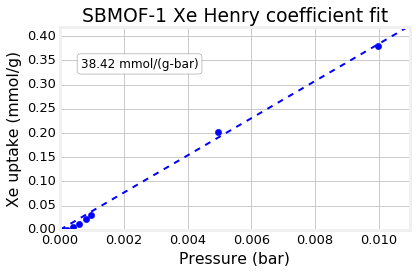

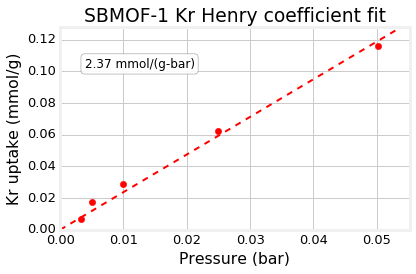

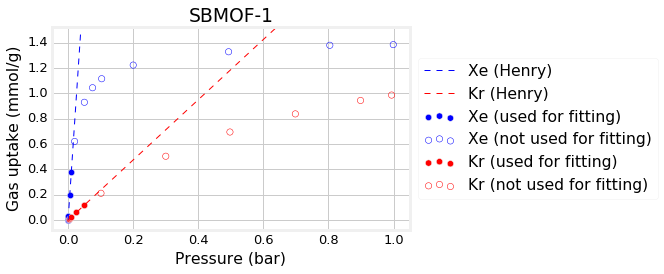

Infinite dilution selectivity =  16.1821605967
Structure :  CC3


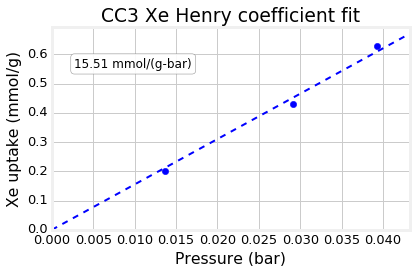

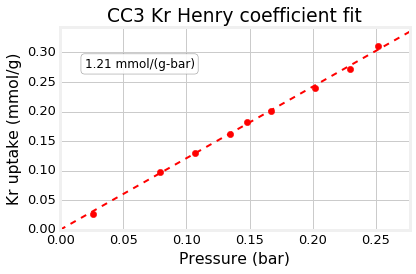

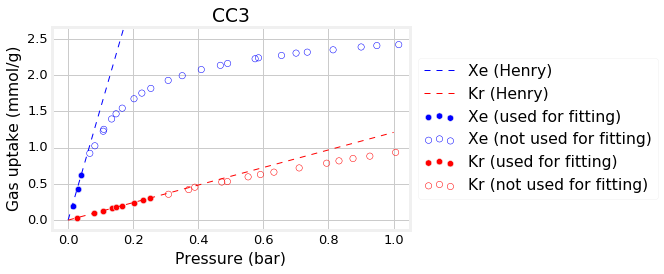

Infinite dilution selectivity =  12.8070463777
Structure :  IRMOF-1
This data is taken at 292 K.


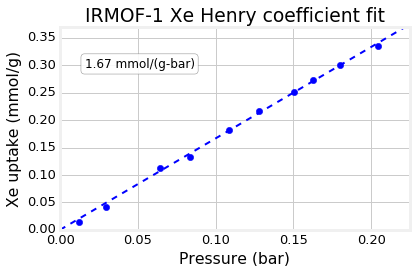

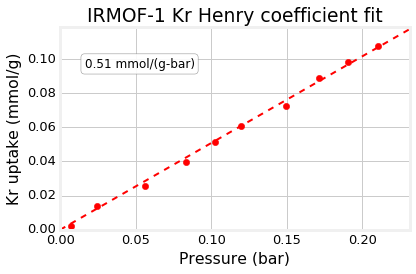

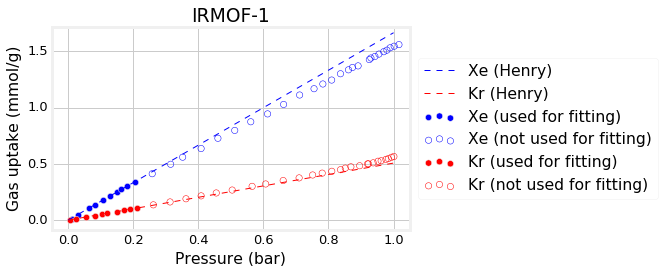

Infinite dilution selectivity =  3.28383872687
Structure :  Ni-MOF-74
The Xe isotherm is at 297 K, while Kr is at 298 K actually.


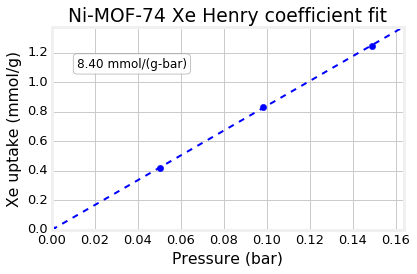

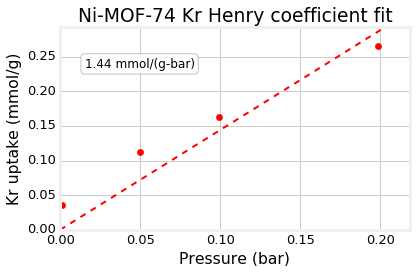

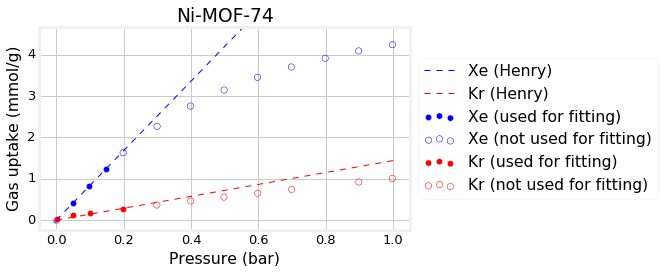

Infinite dilution selectivity =  5.83084738816
Structure :  HKUST-1


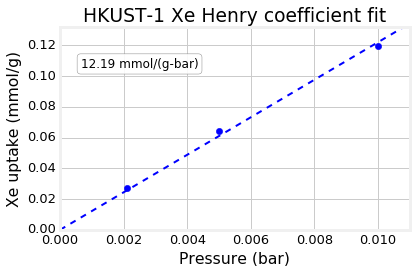

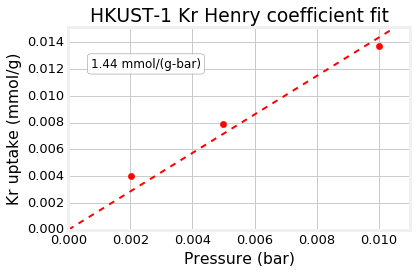

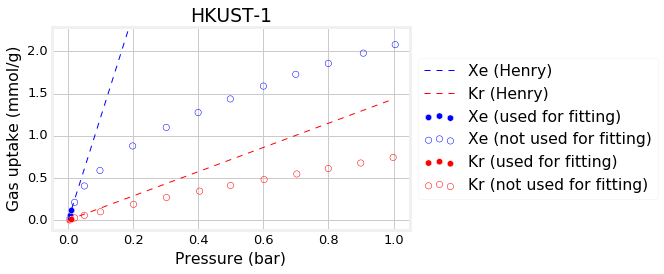

Infinite dilution selectivity =  8.49275948675
Structure :  SBMOF-2


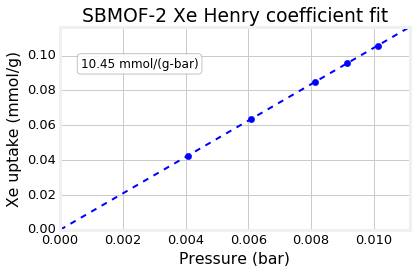

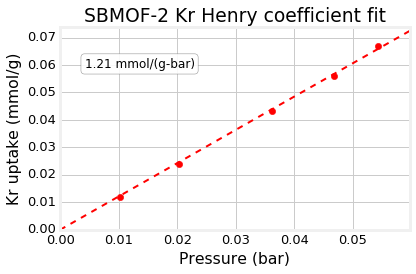

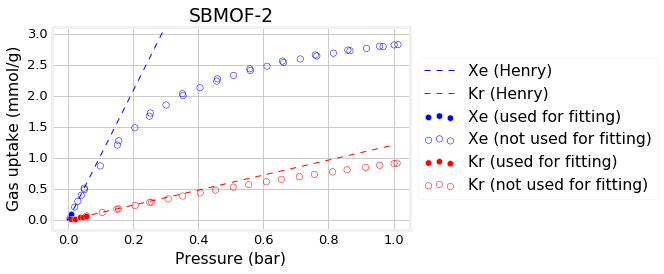

Infinite dilution selectivity =  8.62536977194
Structure :  Co-formate


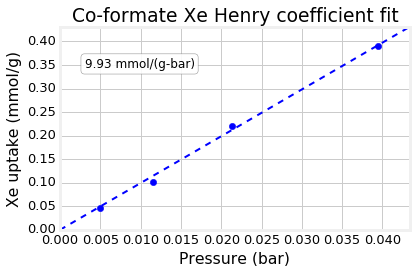

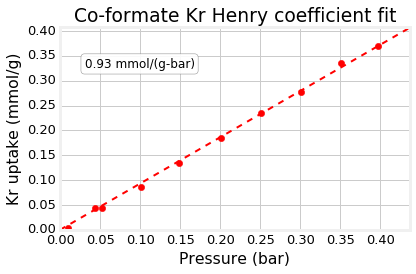

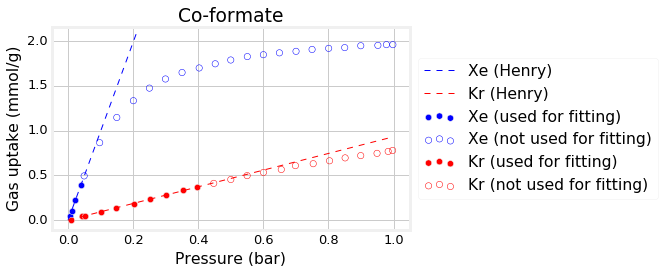

Infinite dilution selectivity =  10.676788077
Structure :  ZincTetrazolate
This MOF is flexible, explaining odd shape.


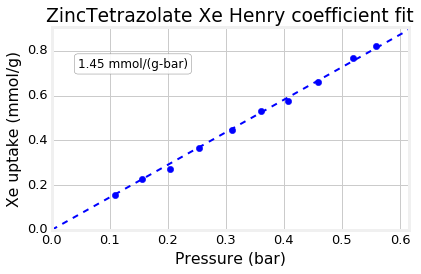

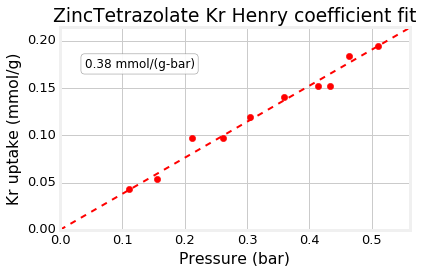

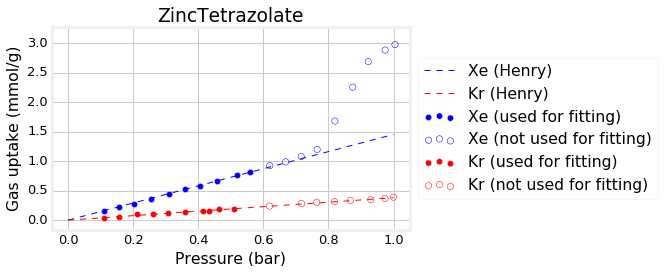

Infinite dilution selectivity =  3.81607948464
Structure :  FMOF-Cu
Data at 297 K actually.


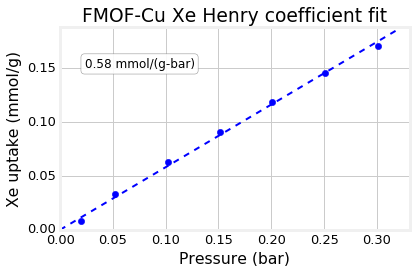

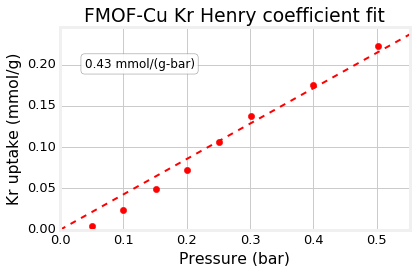

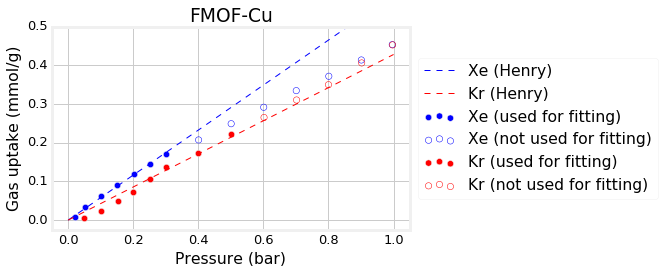

Infinite dilution selectivity =  1.35882167104
Structure :  MOF-505
This data is taken at 292 K


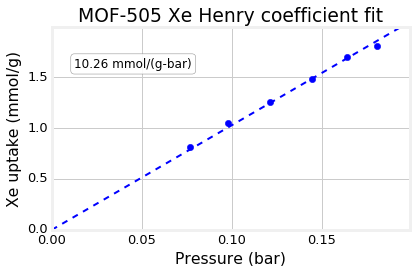

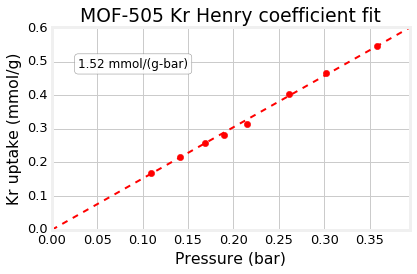

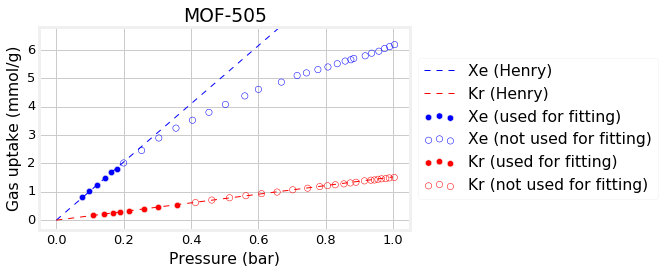

Infinite dilution selectivity =  6.72966820791
Structure :  PCN-14
This data is taken at 292 K


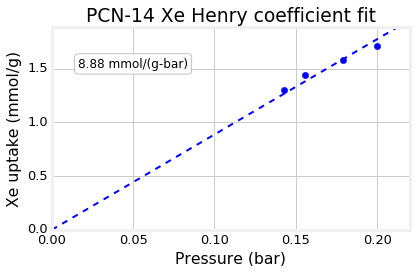

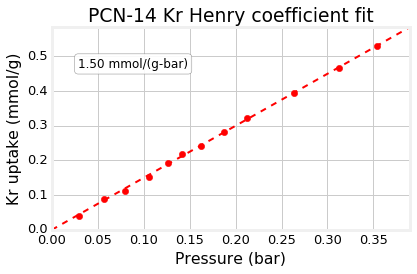

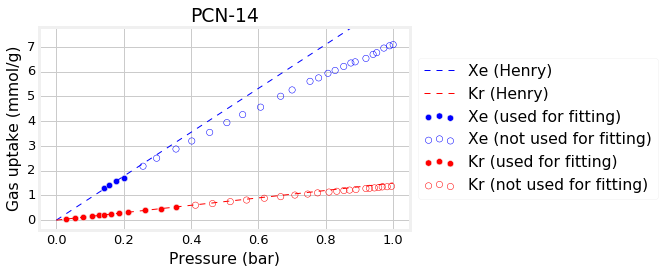

Infinite dilution selectivity =  5.9178214121
Structure :  Noria


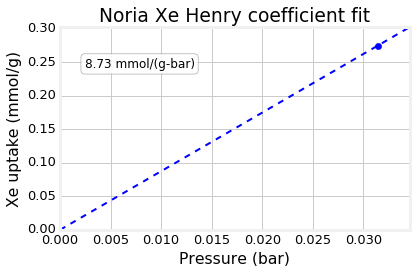

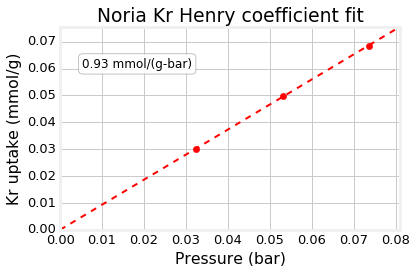

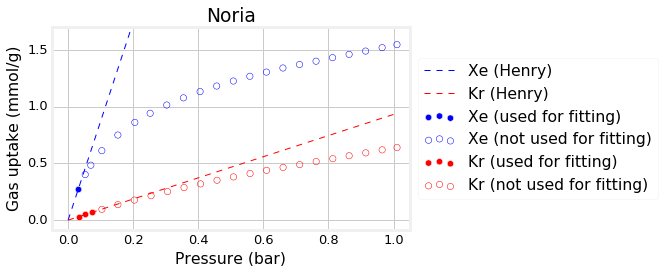

Infinite dilution selectivity =  9.35980318469


In [10]:
for structure in structures:
    print "Structure : ", structure
    if structure in special_notes.keys():
        print(special_notes[structure])
    
    #
    # Load the pure-component adsorption data from .csv files in the `data/` folder.
    #
    df = dict()
    df["Xe"] = pd.read_csv("data/" + structure + "/Xe.csv")
    df["Kr"] = pd.read_csv("data/" + structure + "/Kr.csv")
    
    #
    # Convert units to get adsorption data into consistent units.
    #     Desired pressure unit is bar.
    #     Desired gas uptake unit is mmol/g.
    # So, we make the pressure and loading key in the DataFrame 'P(bar)' and 'L(mmol/g)', respectively.
    # Each structure here gets special treatment since generally the
    #   raw data is in different units.
    #
    if structure in ["PCN-14", "MOF-505"]:
        for gas in ["Xe", "Kr"]:
            df[gas]['P(bar)'] = df[gas]['P(atm)'] * 1.01325
            df[gas]['L(mmol/g)'] = df[gas]['L(cm3STP/g)'] / 22.4
            
    if structure in ['SBMOF-1', "CC3", "Ni-MOF-74", "HKUST-1"]:
        for gas in ["Xe", "Kr"]:
            df[gas]['P(bar)'] = df[gas]['P(mbar)'] / 1000.0
    
    if structure in ["SBMOF-2"]:
        for gas in ["Xe", "Kr"]:
            df[gas]['P(bar)'] = df[gas]['P(torr)'] / 750.062
            df[gas]['L(mmol/g)'] = df[gas]['L(ccSTP/g)'] / 22.4
    
    if structure in ["ZincTetrazolate"]:
        for gas in ["Xe", "Kr"]:
            df[gas]['P(bar)'] = df[gas]['P(kPa)'] * 0.01
    
    if structure == "FMOF-Cu":
        # FMOFCu has a desorption branch. There is hysteresis in the adsorption isotherm.
        # Here, we only use the ADsorption isotherm.
        df["Xe"] = df["Xe"].iloc[:14]
        df["Kr"] = df["Kr"].iloc[:14]
        
    if structure in ["SBMOF-1", "Ni-MOF-74", "HKUST-1"]:
        for gas in ["Xe", "Kr"]:
            df[gas]['L(mmol/g)'] = df[gas]['PercentMass'] / 100.0 / molecular_weight[gas] * 1000.0
    
    if structure == "IRMOF-1":
        rho_IRMOF1 = 593.3065 # crystal density of IRMOF-1, g / L
        for gas in ["Xe", "Kr"]:
            df[gas]['L(mmol/g)'] = df[gas]["L(mol/L)"] / rho_IRMOF1 * 1000.0
            
    if structure == "Noria":
        for gas in ["Xe", "Kr"]:
            df[gas]['P(bar)'] = df[gas]['P(torr)'] / 750.062
    
    # Remove rogue data points with negative loading...
    df["Kr"] = df["Kr"][df["Kr"]['L(mmol/g)'] > 0.0]
    df["Xe"] = df["Xe"][df["Xe"]['L(mmol/g)'] > 0.0]
    
    # sort by pressure
    df["Xe"] = df["Xe"].sort_values(by='P(bar)')
    df["Kr"] = df["Kr"].sort_values(by='P(bar)')
    
    for gas in ["Xe", "Kr"]:
        # get data for regression
        pressures = df[gas]['P(bar)'].values[:num_points_for_henry[gas][structure]]
        loadings = df[gas]['L(mmol/g)'].values[:num_points_for_henry[gas][structure]]
        assert(np.size(pressures) == num_points_for_henry[gas][structure])
        
        # use scikit-learn to fit line with no intercept to data
        regr = linear_model.LinearRegression(fit_intercept=False)
        regr.fit(pressures.reshape(num_points_for_henry[gas][structure], 1), 
                 loadings)
        
        # henry coefficient is the slope
        henry_coefficients[gas][structure] = regr.coef_[0]
        
        # plot fit
        fig = plt.figure()

        plt.xlim([0, np.max(pressures) * 1.1])
        plt.ylim([0, np.max(loadings) * 1.1])

        # plot experimental data points
        plt.scatter(pressures, loadings, s=40,
                    color=gas_colors[gas], label=gas)

        # Plot fitted Henry model predictions
        pressures_ = np.linspace(0, 1.0)
        plt.plot(pressures_, henry_coefficients[gas][structure] * pressures_, 
                 color=gas_colors[gas], linewidth=2, linestyle='--',
                 label="$K_H$: %.2f mmol/(g-bar)" % henry_coefficients[gas][structure])

        plt.ylabel('%s uptake (mmol/g)' % gas)
        plt.xlabel('Pressure (bar)')

        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
        t = plt.text(.25 * np.max(pressures), .9 * np.max(loadings), 
            "%.2f mmol/(g-bar)" % henry_coefficients[gas][structure], ha="center", va="center",
            size=12,
            bbox=bbox_props)

        plt.title("%s %s Henry coefficient fit" % (structure, gas))

        plt.tight_layout()
        plt.savefig("fits/%s_low_pressure_fit_%s.png" % (gas, structure), format='png', dpi=300)
        plt.show()
    
    
    # Selectivity at infinite dilution is the ratio of these Henry constants
    selectivity[structure] = henry_coefficients["Xe"][structure] / henry_coefficients["Kr"][structure]
    
    #
    # Plot all data from 0-1 bar to viz the fit of the Henry coefficient
    #
    fig = plt.figure()
    
    for gas in ["Xe", "Kr"]:
        # use closed symbols for data used for fitting
        plt.scatter(df[gas]['P(bar)'].values[:num_points_for_henry[gas][structure]],
            df[gas]['L(mmol/g)'].values[:num_points_for_henry[gas][structure]],
            label='%s (used for fitting)' % gas, marker='o', s=40, clip_on=False, 
            c=gas_colors[gas])
        
        # use open symbols for data not use for fitting
        plt.scatter(df[gas]['P(bar)'].values[num_points_for_henry[gas][structure]:],
                    df[gas]['L(mmol/g)'].values[num_points_for_henry[gas][structure]:],
                    label='%s (not used for fitting)' % gas, marker='o', s=40, clip_on=False, 
                    facecolors='none', edgecolors=gas_colors[gas])
        
        # henry's law with identified KH
        plt.plot(pressures_, henry_coefficients[gas][structure] * pressures_, color=gas_colors[gas], 
                 linewidth=1, linestyle='--', label='%s (Henry)' % gas)
    
    ymax = 1.1 * df["Xe"]["L(mmol/g)"].max()
    plt.ylim([-0.05 * ymax, ymax])
    plt.xlim([-.05, 1.05])
    
    plt.xlabel('Pressure (bar)') 
    plt.ylabel('Gas uptake (mmol/g)')       

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
        
    plt.title("%s" % structure)
    plt.tight_layout()
    plt.savefig('fits/%s_fit.png' % structure, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print "Infinite dilution selectivity = ", selectivity[structure]

### Load this data into a pandas DataFrame

In [11]:
df = pd.DataFrame()
df['structure'] = structures
df['selectivity'] = [selectivity[structure] for structure in structures]
df['kh_xe'] = [henry_coefficients["Xe"][structure] for structure in structures]
df['kh_kr'] = [henry_coefficients["Kr"][structure] for structure in structures]
df['markertype'] = [solid_markers[i] for i in range(len(structures))]
df['markercolor'] = [colors[i] for i in range(len(structures))]

df = df.sort_values(by="selectivity", ascending=False)
df

,structure,selectivity,kh_xe,kh_kr,markertype,markercolor
0,SBMOF-1,16.182161,38.423772,2.374453,>,"[0.967797559292, 0.441274560092, 0.535810315506]"
1,CC3,12.807046,15.511660,1.211182,<,"[0.903599057665, 0.511987276336, 0.195883500602]"
6,Co-formate,10.676788,9.933919,0.930422,o,"[0.210447538322, 0.677310508046, 0.643394116847]"
11,Noria,9.359803,8.730227,0.932736,*,"[0.963332174206, 0.406438256457, 0.759253759957]"
5,SBMOF-2,8.625370,10.453387,1.211935,p,"[0.203127571979, 0.68812492498, 0.517761816745]"
4,HKUST-1,8.492759,12.194923,1.435920,H,"[0.31268900195, 0.69287546103, 0.192370483033]"
9,MOF-505,6.729668,10.258023,1.524298,s,"[0.642304434922, 0.549768005126, 0.958265143366]"
10,PCN-14,5.917821,8.875863,1.499853,D,"[0.908257243677, 0.401957907297, 0.957690925029]"
3,Ni-MOF-74,5.830847,8.401131,1.440808,v,"[0.592089152964, 0.641846701638, 0.193506913499]"
7,ZincTetrazolate,3.816079,1.453526,0.380895,d,"[0.217867106624, 0.665667160132, 0.748280938507]"


# Summarize with performance plot

Use symols in legend to denote different temperatures.

In [12]:
footnotes_for_legends = dict(zip(structures, [" " for structure in structures]))
for structure in ["IRMOF-1", "PCN-14", "MOF-505"]:
    footnotes_for_legends[structure] = "$^{\dagger \dagger}$"
footnotes_for_legends["FMOF-Cu"] = "$^\dagger$"

/usr/local/lib/python2.7/dist-packages/matplotlib/lines.py:1082: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markeredgecolor != ec:


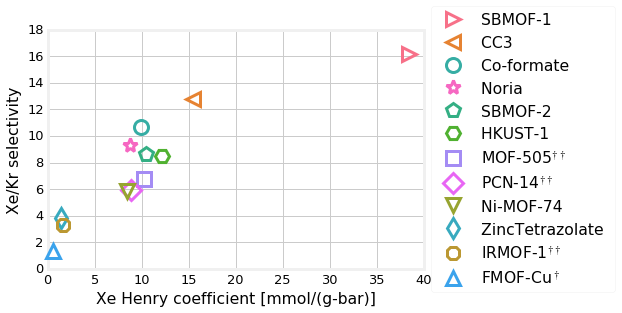

In [13]:
fig = plt.figure(facecolor='w')

for i in range(df.shape[0]):
    plt.plot(df["kh_xe"].iloc[i], df['selectivity'].iloc[i], 
             color=df['markercolor'].iloc[i], marker=df['markertype'].iloc[i], ms=14, 
             label=df['structure'].iloc[i] + footnotes_for_legends[df['structure'].iloc[i]],
             linestyle='None', markevery=1,
             markeredgecolor=df['markercolor'].iloc[i], markerfacecolor='none',
             markeredgewidth=3.0,
             clip_on=False, zorder=100)

plt.xlabel("Xe Henry coefficient [mmol/(g-bar)]")
plt.ylabel("Xe/Kr selectivity")
plt.xlim([0, 40])
plt.ylim([0, 18])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.savefig("performance_plot_only_expt.png", format='png', dpi=300, 
            facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()

### Summary of selectivities

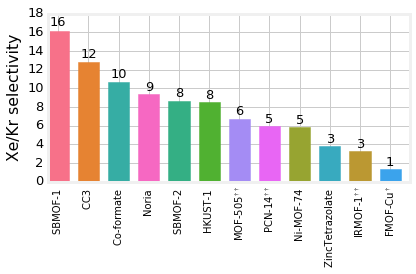

In [14]:
df = df.sort_values(by="selectivity", ascending=False)

ind = np.arange(len(structures))  # the x locations for the groups
width = 0.7       # the width of the bars

fig, ax = plt.subplots(facecolor='w')
rects = ax.bar(ind, df["selectivity"].values, width)
[rects[i].set_color(df["markercolor"].iloc[i]) for i in range(len(structures))]

# add some text for labels, title and axes ticks
ax.set_ylabel('Xe/Kr selectivity')
ax.set_xticks(ind + width/2.0)
ax.set_xticklabels([structure + footnotes_for_legends[structure] for structure in df["structure"].values])

# ax.legend((rects1[0], rects2[0]), ('dilute conditions', '20/80 mol% Xe/Kr, 298 K, 1 bar'), prop={'size':12} )

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        if np.isnan(rect.get_height()):
            continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01 * height, '%d' % int(height),
                ha='center', va='bottom')
        
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
autolabel(rects)

plt.tight_layout()

plt.savefig('selectivities.png', format='png', dpi=300, facecolor=fig.get_facecolor())

plt.show()

### Rank by and visualize Henry coefficients
##### Kr

In [ ]:
df = df.sort_values("kh_kr", ascending=False)

plt.figure(facecolor='w')
plt.bar(np.arange(df.shape[0]), df['kh_kr'], color=df['markercolor'])
plt.xticks(np.arange(df.shape[0])+0.5, 
           [structure + footnotes_for_legends[structure] for structure in df["structure"].values],
           rotation=90)
plt.ylabel("$K_{H, Kr}$ (mmol/[g-bar])")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.tight_layout()
plt.savefig('Kr_performance.png', format='png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

##### Xe

In [ ]:
df = df.sort_values("kh_xe", ascending=False)

plt.figure(facecolor='w')
plt.bar(np.arange(df.shape[0]), df['kh_xe'], color=df['markercolor'])
plt.xticks(np.arange(df.shape[0])+0.5, 
           [structure + footnotes_for_legends[structure] for structure in df["structure"].values],
           rotation=90)
plt.ylabel("$K_{H, Xe}$ (mmol/[g-bar])")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.tight_layout()
plt.savefig('Xe_performance.png', format='png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

FMOF-Cu should not be included because its pores are likely not accessible to xenon.

# Compare simulated selectivities to simulations

Load simulated Xe/Kr Henry coefficients in structures present in the folder `xtal_structures`.

We utilized the Universal Force Field for MOF atoms; doi:10.1016/0031-8914(61)90072-6 for Xe-Xe. Lorenz-Berthelot mixing rules for cross-interactions.

In [ ]:
df_sim = pd.read_csv("XeKr_simulated_data.csv", skiprows=1, comment="#")
df_sim["selectivity_simulated"] = df_sim["KH_Xe(mol/kg-Pa)"] / df_sim["KH_Kr(mol/kg-Pa)"]
df_sim

Merge this simulated selecitivity with DataFrame `df` where experimental selectivities are stored.

In [ ]:
df = pd.merge(df, df_sim[['structure', 'selectivity_simulated']], on='structure')
assert(df.shape[0] == len(structures) - 1) # -1 for Noria

Fit a linear model to the experimental versus simulated selectivities using Scikit-learn's `LinearRegression` object.

In [ ]:
regr = linear_model.LinearRegression()

Train the model; we choose x to be the simulated selectivities and y to be the experimental selectivities, with the view that the prediction leads to a response of measuring the selectivity.

Do not include FMOF-Cu since its pockets are not accessible to Xe.

In [ ]:
idx = df['structure'].values != 'FMOF-Cu'
regr.fit(df["selectivity_simulated"].values[idx].reshape(sum(idx), 1), 
         df["selectivity"].values[idx])

Compute $R^2$ value of linear regression; first argument is truth, second is prediction.

In [ ]:
R2 = r2_score(df["selectivity"].values[idx], 
              regr.predict(df["selectivity_simulated"].values[idx].reshape(sum(idx), 1)))
R2

In [ ]:
fig = plt.figure(facecolor='w')

plt.xlabel('Simulated Xe/Kr selectivity')
plt.ylabel('Measured Xe/Kr selectivity')

for i in range(df.shape[0]):
    # Ignore FMOF-Cu since its pores are not accessible to Xe
    if df['structure'].iloc[i] in ["FMOF-Cu"]:
        continue
        
    plt.plot(df["selectivity_simulated"].iloc[i], df["selectivity"].iloc[i], 
             color=df['markercolor'].iloc[i], 
             marker=df['markertype'].iloc[i], ms=10, 
             label=df['structure'].iloc[i] + footnotes_for_legends[df['structure'].iloc[i]],
             linestyle='None',
             markeredgecolor=df['markercolor'].iloc[i], markerfacecolor=df['markercolor'].iloc[i],
             markeredgewidth=3.0,
             clip_on=False, zorder=100)
    
# linear regression
plt.plot(np.linspace(0, 80), regr.predict(np.linspace(0, 80).reshape(50,1)), 
         linewidth=1, color='k', linestyle='--')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
t = plt.text(55, 11, "$R^2=$%.2f" % R2, ha="center", va="center",
            size=15,
            bbox=bbox_props)
plt.ylim([0, 18])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.tight_layout()
plt.savefig('Expt_vs_sim_inf_dil.pdf', format='pdf', facecolor='w', bbox_inches='tight')
plt.savefig('Expt_vs_sim_inf_dil.png', format='png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

# Generate LaTeX to display results
This code assumes we have a .png file visualizing the crystal structure in the `xtal_structures/viz` directory.

In [ ]:
def get_LaTeX_figure_code(structure, temperature):
    """
    Generate LaTeX code to summarize results for a given structure.
    """
    code = r"""
    \section{{{0}}}
    
    \begin{{figure}}[h!]
       \centering
       \subfigure[]{{\includegraphics[width=.3\columnwidth]{{../xtal_structures/viz/{0}.png}} \label{{fig:{0}_xtal}} }}
       \subfigure[]{{\includegraphics[width=.6\columnwidth]{{../fits/{0}_fit.png}} \label{{fig:{0}_xtal}} }}
  
       \subfigure[]{{\includegraphics[width=.45\columnwidth]{{../fits/Xe_low_pressure_fit_{0}.png}} \label{{fig:{0}_Xe_KH}} }}
       \subfigure[]{{\includegraphics[width=.45\columnwidth]{{../fits/Kr_low_pressure_fit_{0}.png}} \label{{fig:{0}_Kr_KH}} }}
       
       \caption{{{0}. (a) Crystal structure \cite{{{0}_structure}}.
       (b) Circles show pure-component Xe (blue) and Kr (red) adsorption isotherm data at {1} K from Ref. \cite{{{0}_XeKr}}. 
       Closed symbols are data used to identify the Henry coefficient. The dashed line shows Henry's law with the identified Henry coefficient.
       (c, d) Same as (b) but zoomed into the Henry regime. Identified Henry coefficient is shown in the box.}}
    \end{{figure}}
    
    \clearpage
    
    """.format(structure, temperature)
    return code

Temperatures at which Xe/Kr isotherms were collected, to put in caption

In [ ]:
temperatures = dict(zip(structures, [298 for structure in structures]))
for structure in ["IRMOF-1", "MOF-505", "PCN-14"]:
    temperatures[structure] = 292
temperatures["FMOF-Cu"] = 297

Make LaTeX code for all structures. Put into a single file `allfigs.tex`.

In [ ]:
f = open("LaTeX/allfigs.tex", "w")
for structure in structures:
    code = get_LaTeX_figure_code(structure, temperatures[structure])
    f.write(code)
f.close()

# Accessible surface areas and largest included sphere diameters
Calculated from Zeo++, in `xtal_structures/surface_areas.csv` and `xtal_structures/pores.csv`

In [ ]:
df_sa = pd.read_csv("xtal_structures/surface_areas.csv")
df_sa.head()

In [ ]:
df_pores = pd.read_csv("xtal_structures/pores.csv")
df_pores.head()

Assert all structures are here.

In [ ]:
for structure in structures:
    if structure not in df_sa["structure"].values:
        raise Exception("Simulated data for %s not present." % structure)
    if structure not in df_pores["structure"].values:
        raise Exception("Simulated data for %s not present." % structure)

In [ ]:
df = pd.merge(df, df_sa, on='structure')
df = pd.merge(df, df_pores, on='structure')

In [ ]:
df = df.sort_values("surfacearea(m2/g)", ascending=False)

fig, ax = plt.subplots(facecolor='w')
rects = plt.bar(np.arange(df.shape[0]), df['surfacearea(m2/g)'], color=df['markercolor'])
# autolabel(rects)
plt.xticks(np.arange(df_sa.shape[0])+0.5, 
           df["structure"],
           rotation=90)
plt.ylabel("Surface area (m$^2$/g)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.tight_layout()
plt.savefig('surface_areas.png', format='png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

In [ ]:
df = df.sort_values("di(A)", ascending=False)

fig, ax = plt.subplots(facecolor='w')
rects = plt.bar(np.arange(df.shape[0]), df['di(A)'], color=df['markercolor'])
autolabel(rects)
plt.xticks(np.arange(df_sa.shape[0])+0.5, 
           df["structure"],
           rotation=90)
plt.ylabel("$D_i$ ($\AA$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
plt.tight_layout()
plt.savefig('pores.png', format='png', dpi=200, facecolor=fig.get_facecolor())
plt.show()